In [1]:
use_gpu = False

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import os
import sys
sys.path.insert(0, '..')

if use_gpu:
    from utils.gpu_tools import *
    os.environ["CUDA_VISIBLE_DEVICES"] = ','.join([ str(obj) for obj in select_gpu(query_gpu())])

os.environ["CUDA_LAUNCH_BLOCKING"] = '1'

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

torch.manual_seed(42)

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}  

## load data

In [3]:
year_list = np.arange(2001,2020,1)

In [4]:
images = []
label_df = []
for year in year_list:
    images.append(np.memmap(os.path.join("../monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20])))
    label_df.append(pd.read_feather(os.path.join("../monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))
    
images = np.concatenate(images)
label_df = pd.concat(label_df)

print(images.shape)
print(label_df.shape)

(1403975, 64, 60)
(1403975, 8)


## build dataset

In [5]:
class MyDataset(Dataset):
    
    def __init__(self, img, label):
        self.img = torch.Tensor(img.copy())
        self.label = torch.Tensor(label)
        self.len = len(img)
  
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx]

In [6]:
dataset = MyDataset(images, (label_df.Ret_20d > 0).values)

In [7]:
test_dataloader = DataLoader(dataset, batch_size=2048, shuffle=False)

# the neural network

In [8]:
net_path = '../pt/20231110_003032/baseline_epoch_5_train_0.694151_val_0.696329.pt'

In [9]:
from models import baseline
device = 'cuda' if use_gpu else 'cpu'

In [10]:
net = torch.load(net_path)


## test

In [11]:
def eval_loop(dataloader, net, loss_fn):
    
    running_loss = 0.0
    total_loss = 0.0
    current = 0
    net.eval()
    target = []
    predict = []
    with torch.no_grad():
        with tqdm(dataloader) as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device)
                y_pred = net(X)
                target.append(y.detach())
                predict.append(y_pred.detach())
                loss = loss_fn(y_pred, y.long())
                
                running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
                current += len(X)
                t.set_postfix({'running_loss':running_loss})
            
    return total_loss, torch.cat(predict), torch.cat(target)

In [12]:
loss_fn = nn.CrossEntropyLoss()
test_loss, y_pred, y_target = eval_loop(test_dataloader, net, loss_fn)

predict_logit = (torch.nn.Softmax(dim=1)(y_pred)[:,1]).cpu().numpy()

100%|██████████| 686/686 [53:28<00:00,  4.68s/it, running_loss=0.692]


## Plot the performance

In [13]:
from matplotlib import pyplot as plt

### Same Weighted

In [14]:
threshold = 0.

label_df['ret'] = (predict_logit>threshold) * label_df.Ret_20d
label_filtered = label_df[predict_logit>threshold]
ret_baseline = label_filtered .groupby(['Date'])['Ret_20d'].mean()

threshold = 0.58

label_df['ret'] = (predict_logit>threshold) * label_df.Ret_20d
label_filtered = label_df[predict_logit>threshold]
ret_cnn = label_filtered .groupby(['Date'])['Ret_20d'].mean()


#### number of stocks selected by time

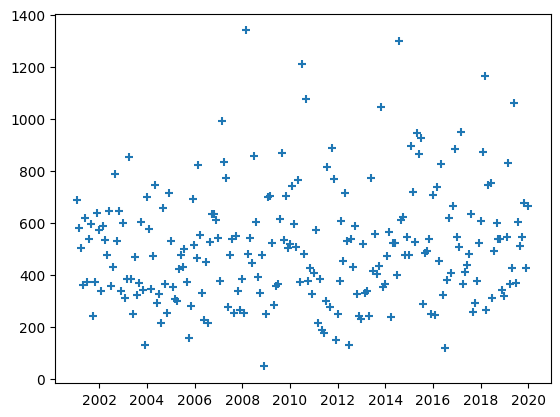

In [15]:
plt.scatter(label_filtered.groupby(['Date'])['ret'].count().index, label_filtered.groupby(['Date'])['ret'].count(),marker='+')

### Compare of log accumulate return

C:\Users\shoge\AppData\Local\Temp\ipykernel_22664\1188020696.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  log_ret_baseline = np.log10((ret_baseline+1).cumprod().fillna(method='ffill'))
C:\Users\shoge\AppData\Local\Temp\ipykernel_22664\1188020696.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  log_ret_cnn = np.log10((ret_cnn+1).cumprod().fillna(method='ffill'))


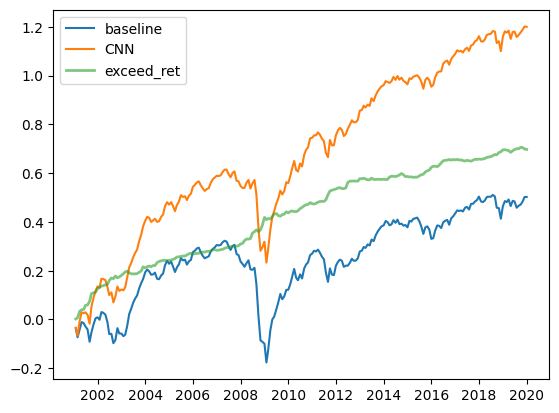

In [16]:
log_ret_baseline = np.log10((ret_baseline+1).cumprod().fillna(method='ffill'))
log_ret_cnn = np.log10((ret_cnn+1).cumprod().fillna(method='ffill'))
fig = plt.figure()
plt.plot(log_ret_baseline, label='baseline')
plt.plot(log_ret_cnn, label='CNN')
plt.plot(log_ret_cnn - log_ret_baseline, alpha=0.6, lw=2, label='exceed_ret')
plt.legend()
plt.show()
fig.savefig('../pic/performance1.png',dpi=300)


In [22]:
import pandas as pd
import numpy as np

def analyze_performance(return_streams):
    results = {}

    for strategy, returns in return_streams.items():
        # Ensure the returns are a Pandas Series
        if not isinstance(returns, pd.Series):
            returns = pd.Series(returns)

        # Calculations
        # Sharpe Ratio
        sharpe_ratio = returns.mean() / returns.std()

        # Max Drawdown
        rolling_max = returns.cummax()
        drawdown = (returns - rolling_max) / rolling_max
        max_drawdown = drawdown.min()

        # Sortino Ratio
        target_return = 0
        downside_returns = returns[returns < target_return]
        sortino_ratio = (returns.mean() - target_return) / downside_returns.std()

        # Turnover (Assuming we need additional data like portfolio holdings)
        # turnover = ... (This metric typically requires holdings data)

        # Additional Metrics (like Alpha, Beta, Annualized Return, Volatility)
        # Assuming a risk-free rate of 0 for simplicity
        annualized_return = (1 + returns.mean()) ** 252 - 1  # 252 trading days
        volatility = returns.std() * np.sqrt(252)

        # Compile the results
        results[strategy] = {
            "Sharpe Ratio": sharpe_ratio,
            "Max Drawdown": max_drawdown,
            "Sortino Ratio": sortino_ratio,
            "Annualized Return": annualized_return,
            "Volatility": volatility
        }

    return pd.DataFrame(results)

# Example usage
return_streams = {
    "CNN 1": ret_cnn,  # Replace with actual returns
    "Baseline 2": ret_baseline   # Replace with actual returns
}

analyze_performance(return_streams)


,CNN 1,Baseline 2
Sharpe Ratio,0.241435,0.120247
Max Drawdown,-2.571820,-3.221633
Sortino Ratio,0.308853,0.150579
Annualized Return,31.125952,4.322471
Volatility,0.911550,0.878792


C:\Users\shoge\AppData\Local\Temp\ipykernel_22664\3359981319.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  plt.plot((ret_cnn+1).cumprod().fillna(method='ffill'), label='CNN_accumulate_ret')


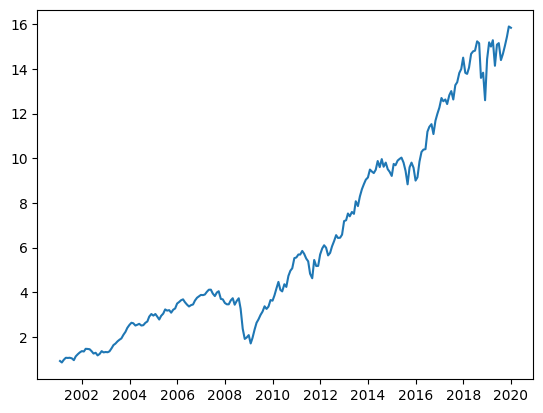

In [17]:
plt.plot((ret_cnn+1).cumprod().fillna(method='ffill'), label='CNN_accumulate_ret')
plt.savefig('../pic/performance2.png',dpi=300)

## Weighted by EWMA_Vol

In [313]:
label_df['weighted_ret'] = 1 * label_df.Ret_20d * label_df['EWMA_vol']
label_df['weight'] = 1 * label_df['EWMA_vol']
ret_baseline = label_df.groupby(['Date'])['weighted_ret'].sum()/(label_df.groupby(['Date'])['weight'].sum())

threshold = 0.58

label_df['weighted_ret'] = (predict_logit>threshold) * label_df.Ret_20d * label_df['EWMA_vol']
label_df['weight'] = (predict_logit>threshold) * label_df['EWMA_vol']
ret_cnn = label_df.groupby(['Date'])['weighted_ret'].sum()/(label_df.groupby(['Date'])['weight'].sum())

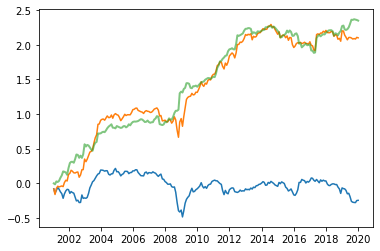

In [314]:
log_ret_baseline = np.log10((ret_baseline+1).cumprod().fillna(method='ffill'))
log_ret_cnn = np.log10((ret_cnn+1).cumprod().fillna(method='ffill'))
plt.plot(log_ret_baseline)
plt.plot(log_ret_cnn)
plt.plot(log_ret_cnn - log_ret_baseline, alpha=0.6, lw=2)